# How to Use the IBM Watson Tone Analyzer to Perform Emotional Sentiment Analysis in Python

## How to use the IBM Watson Artificial Intelligence platform to predict the emotion a customer was feeling when they wrote a product review or provided free-text feedback.

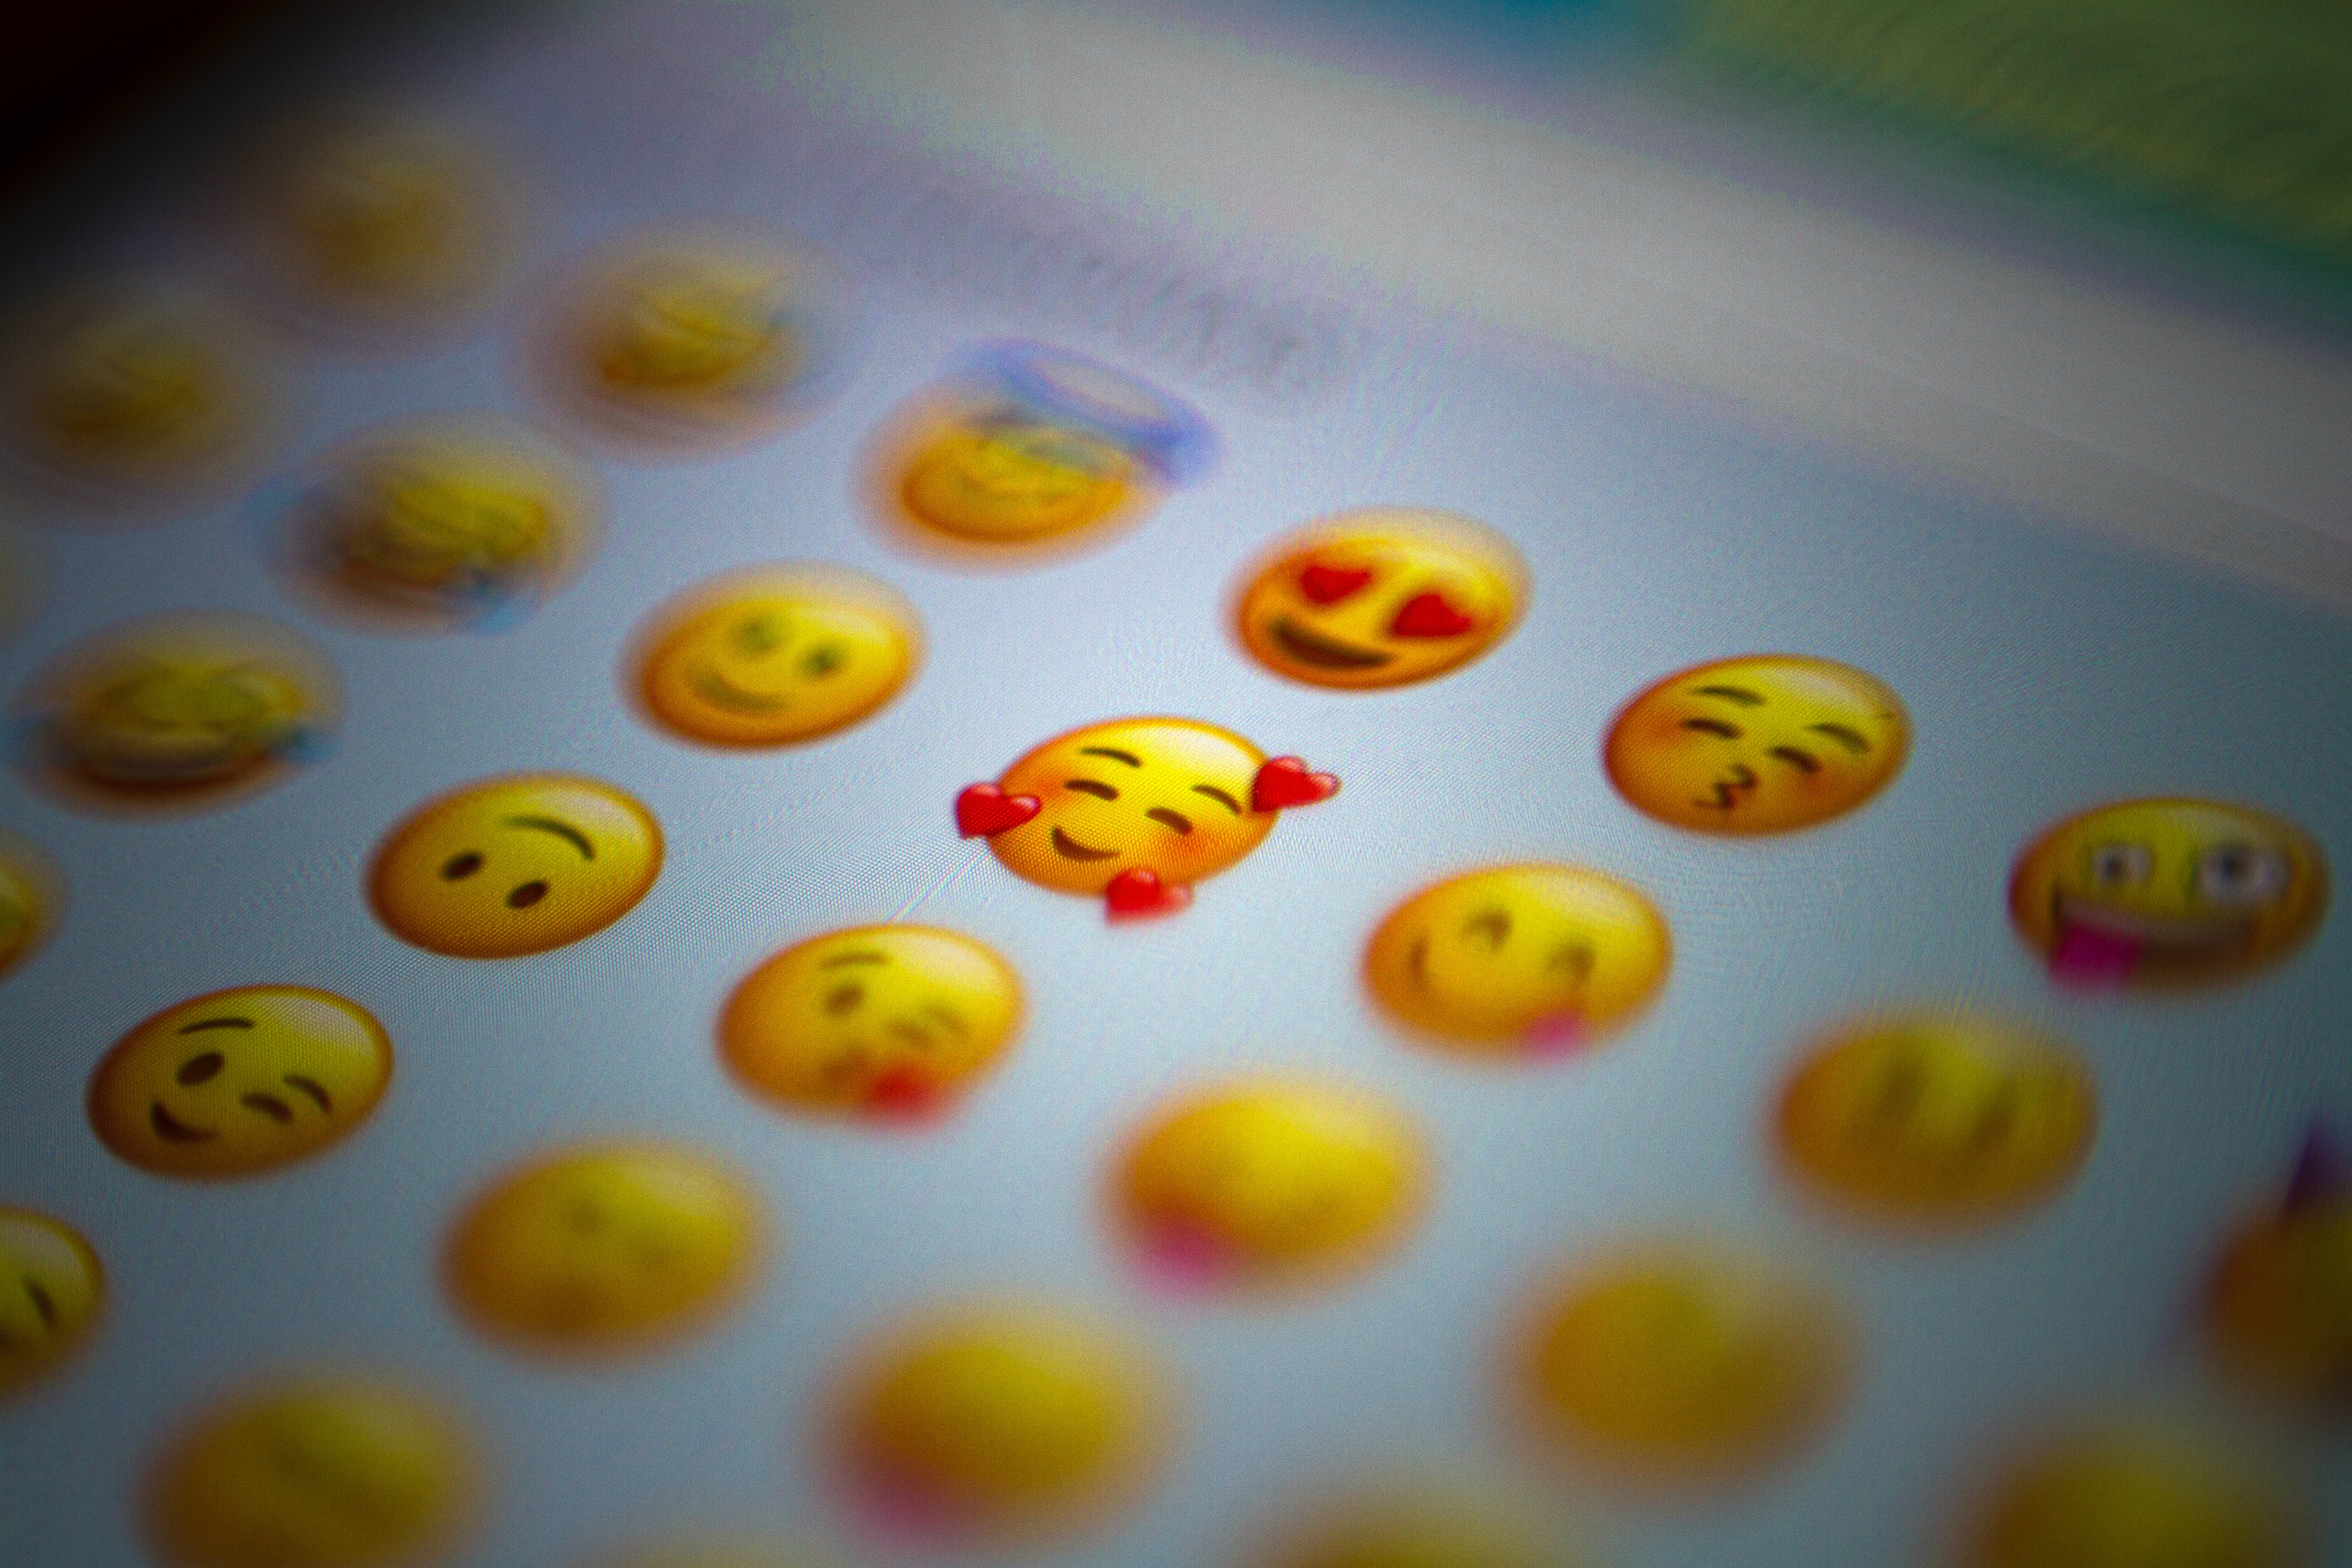
Photo by <a href="https://unsplash.com/@domingoalvarze?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Domingo Alvarez E</a> on <a href="https://unsplash.com/s/photos/emotions?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

### Introduction
It is a common use case to collect customer feedback in the format of free text and then analyze that feedback to translate the views of customers into improvements in products and services.

One approach to carrying out this type of analysis is to take the free text and to perform some feature engineering on it such that the qualitative free text gains more quantitative features. 

For example, if you knew whether the customer was feeling joy, anger, sadness etc. when they wrote the feedback this would provide a useful insight into the customers views which can then be used to develop the data into information, intelligence and knowledge leading to insight-driven action and improved business outcomes.

IBM Watson is "IBM’s portfolio of business-ready tools, applications and solutions, designed to reduce the costs and hurdles of AI adoption while optimizing outcomes and responsible use of AI" (https://www.ibm.com/uk-en/watson).

The "Tone Analyzer" enables the emotional analysis of text to be directly embedded into machine learning applications written in Python (or other languages) and there are free pricing plans available to use for testing and development purposes.

### Getting Started
Before you can start using the IBM Watson Emotional Tone Analyser you will need to register for an account and create a URL and API Key ...

#### 1. Creating an IBM Watson Account
Start by navigating to https://cloud.ibm.com/login and then click on "Create an account". You will be presented with a screen to create an account as follows -

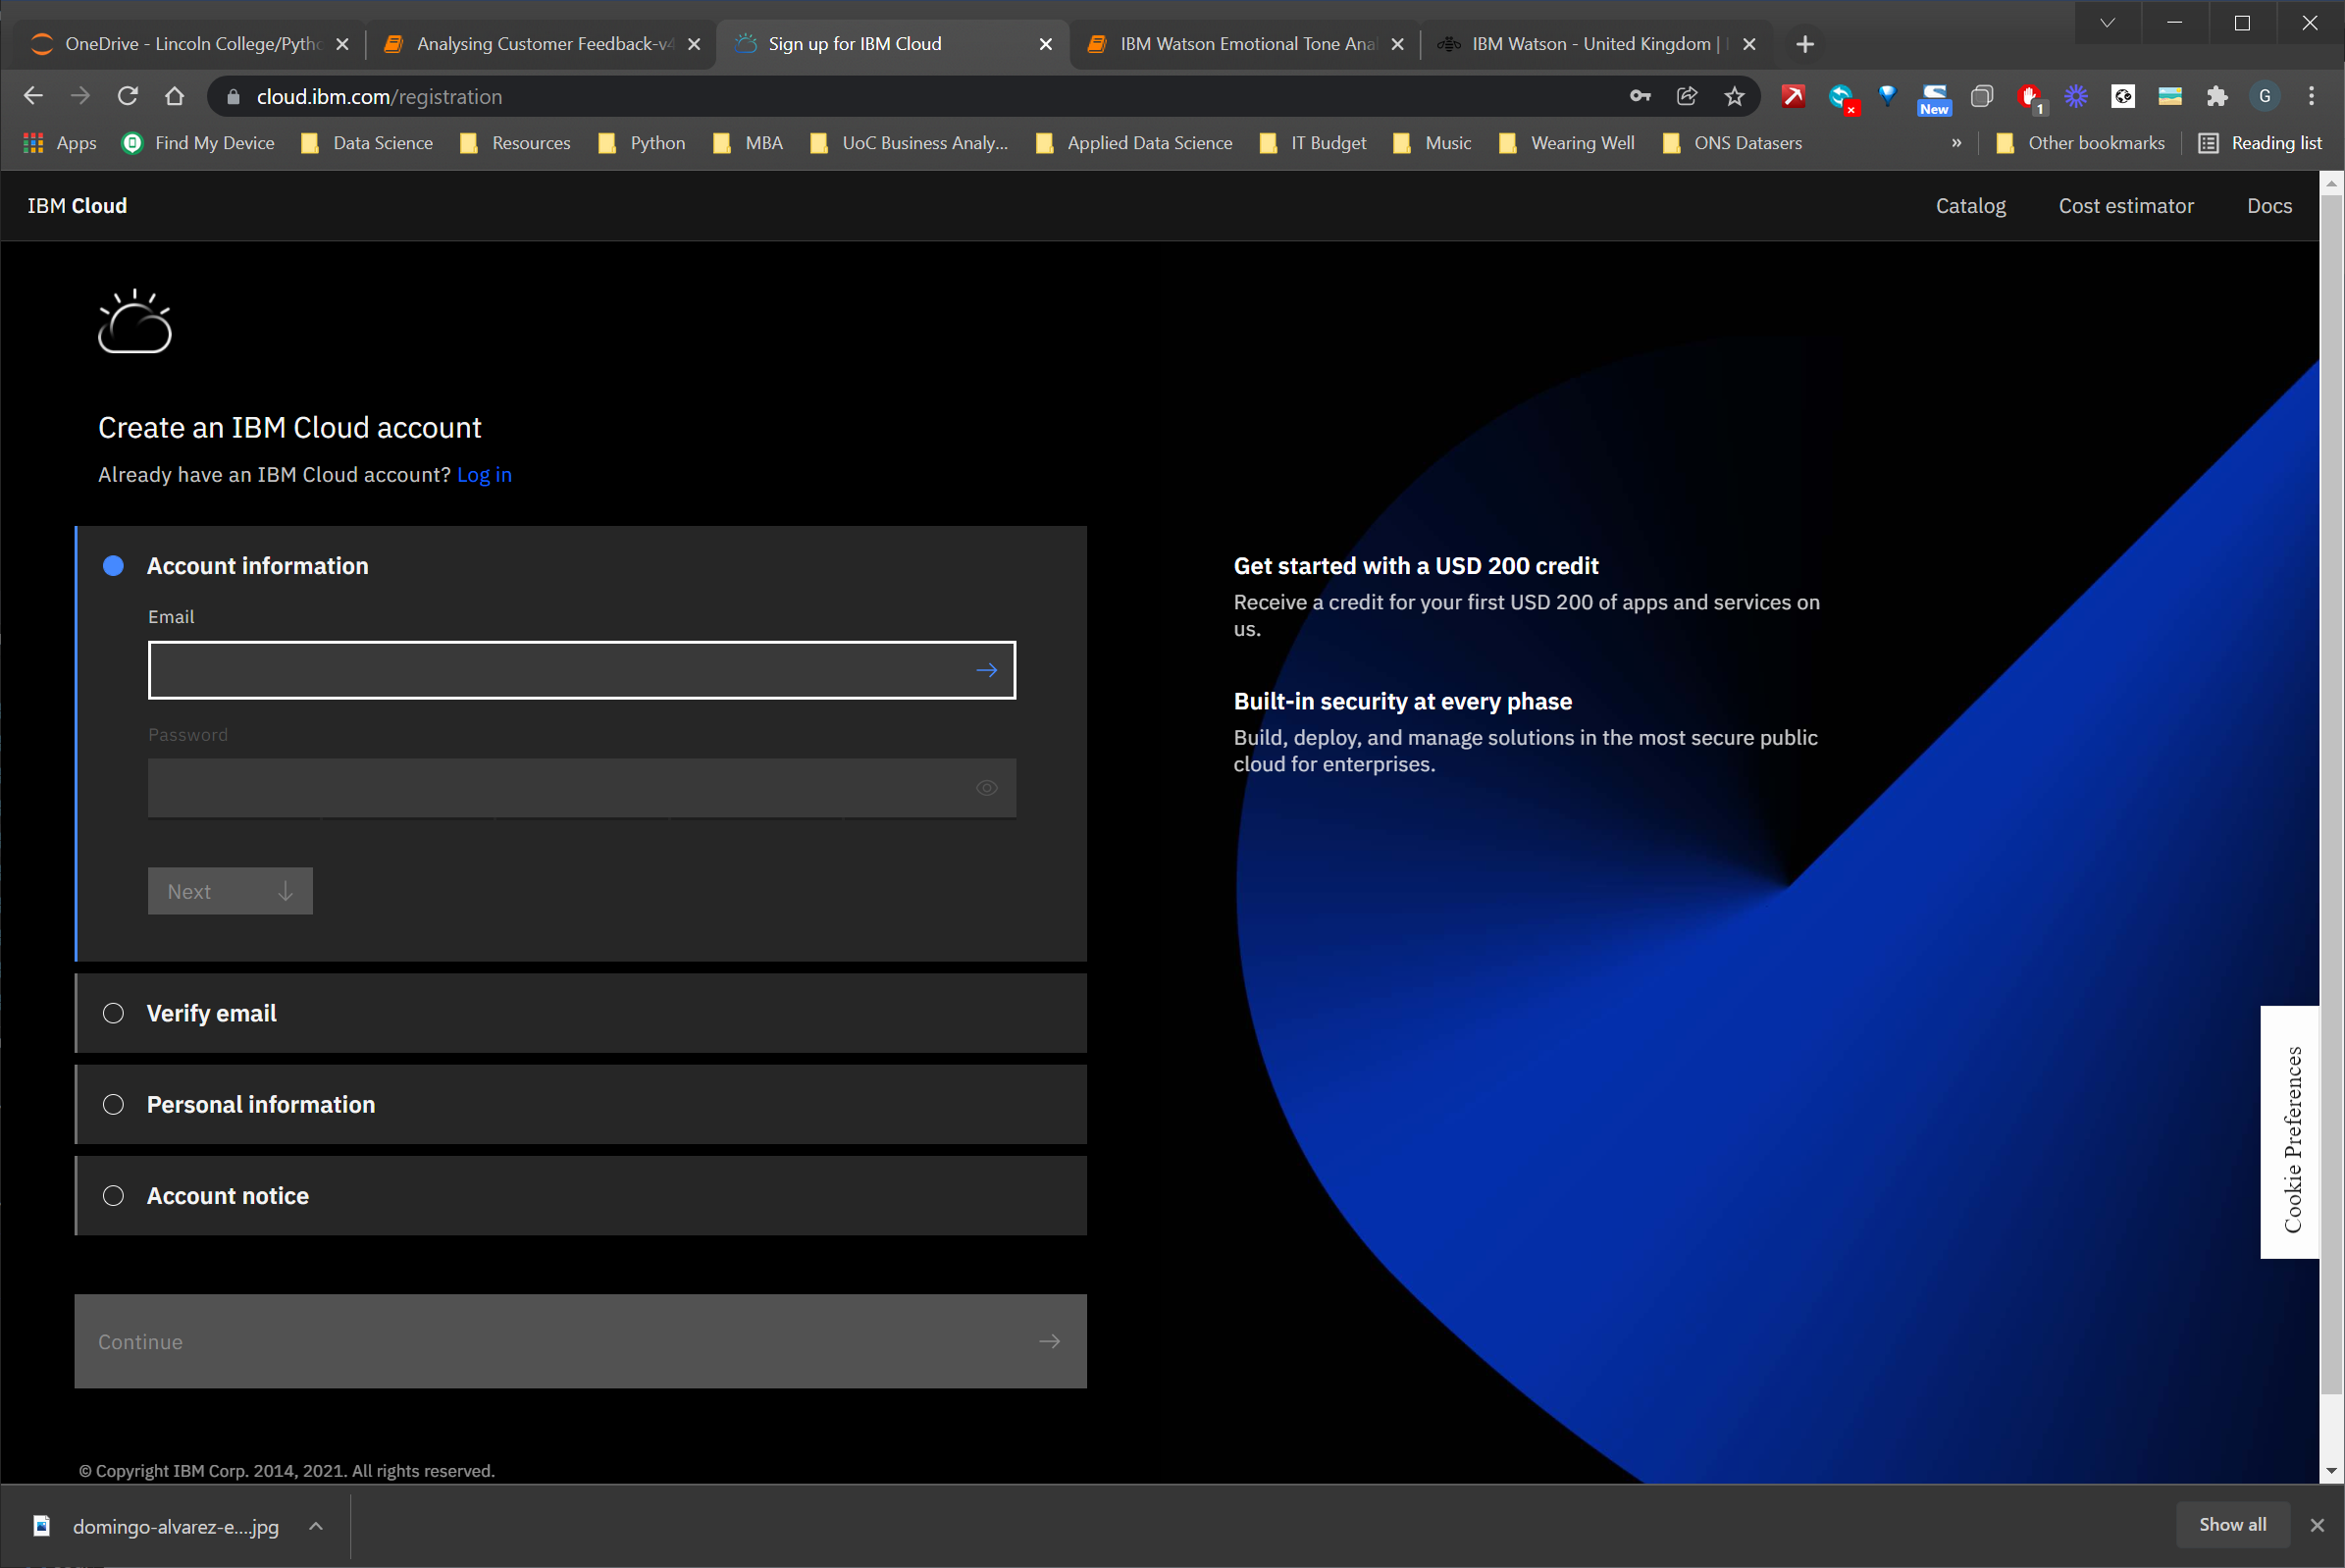
Image by Author

Once you have successfully registered and logged in you will be presented with the following IBM Watson dashboard -

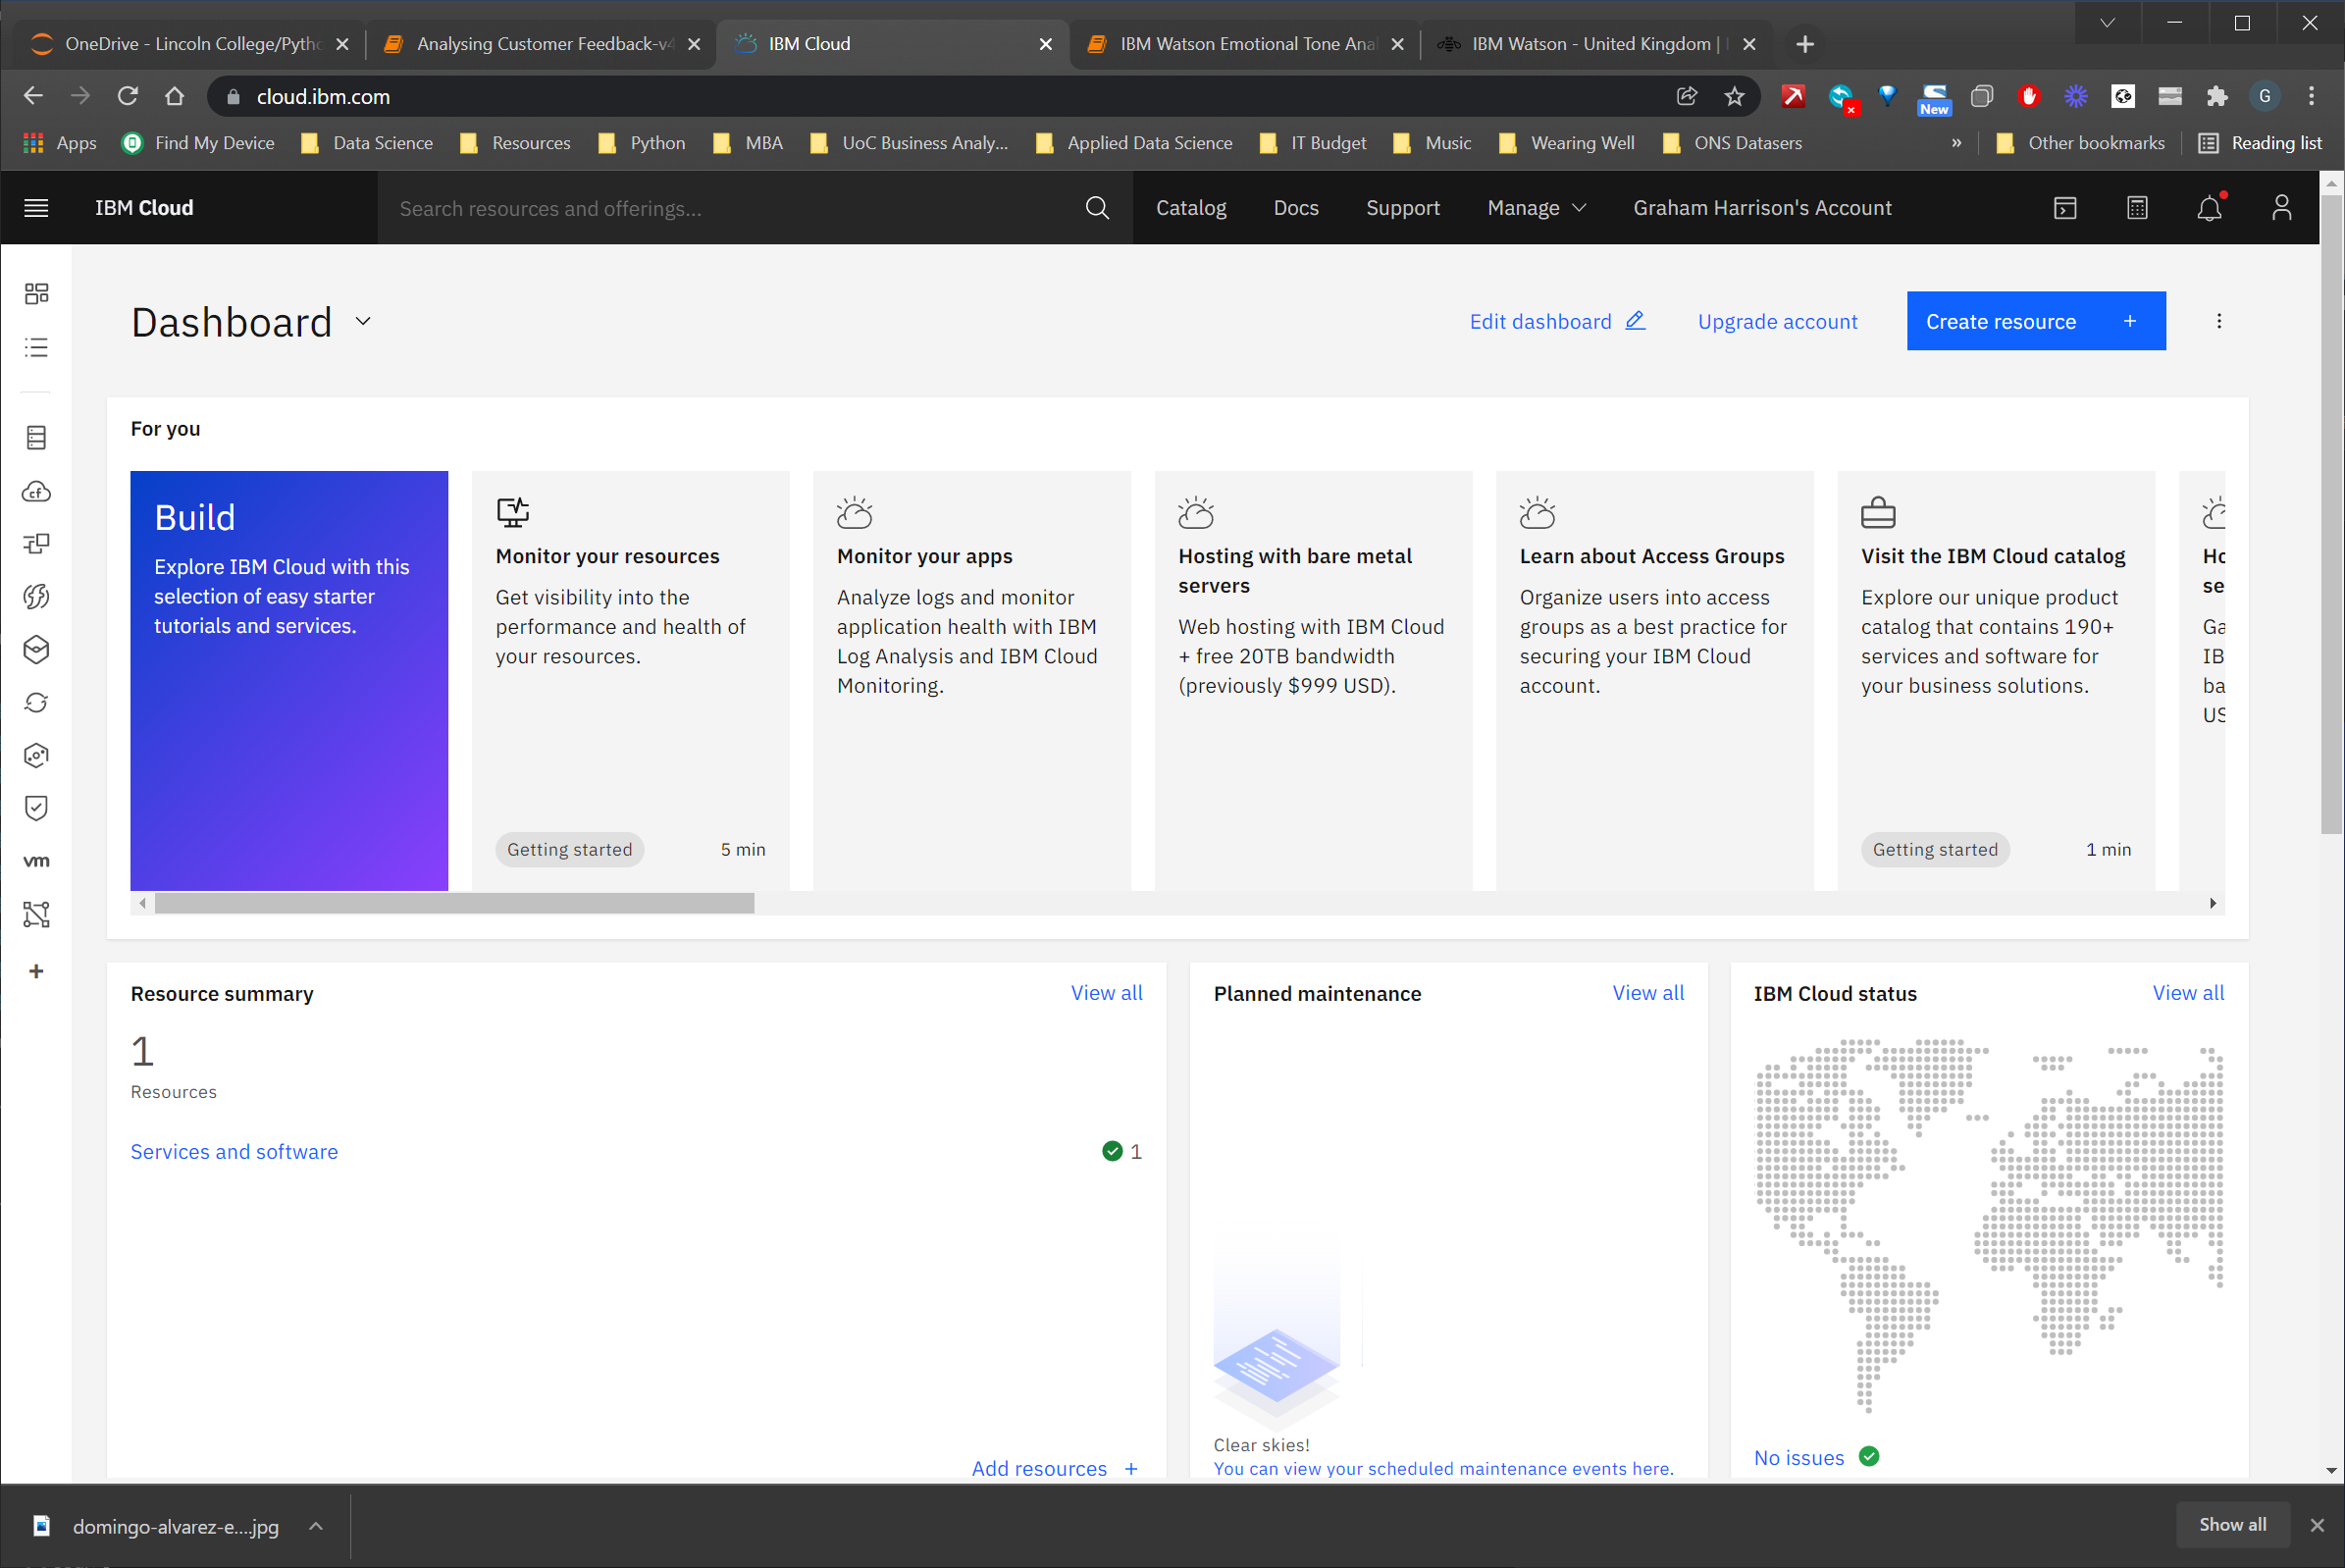
Image by Author

#### 2. Create A Pricing Plan for the Tone Analyzer
The IBM Watson studio environment can be quite unintuitive to navigate around so the best way to start is to click in the "Search resources and offerings" and enter "tone analyzer". This will provide a link to the page with the tone analyzer pricing plans as follows -

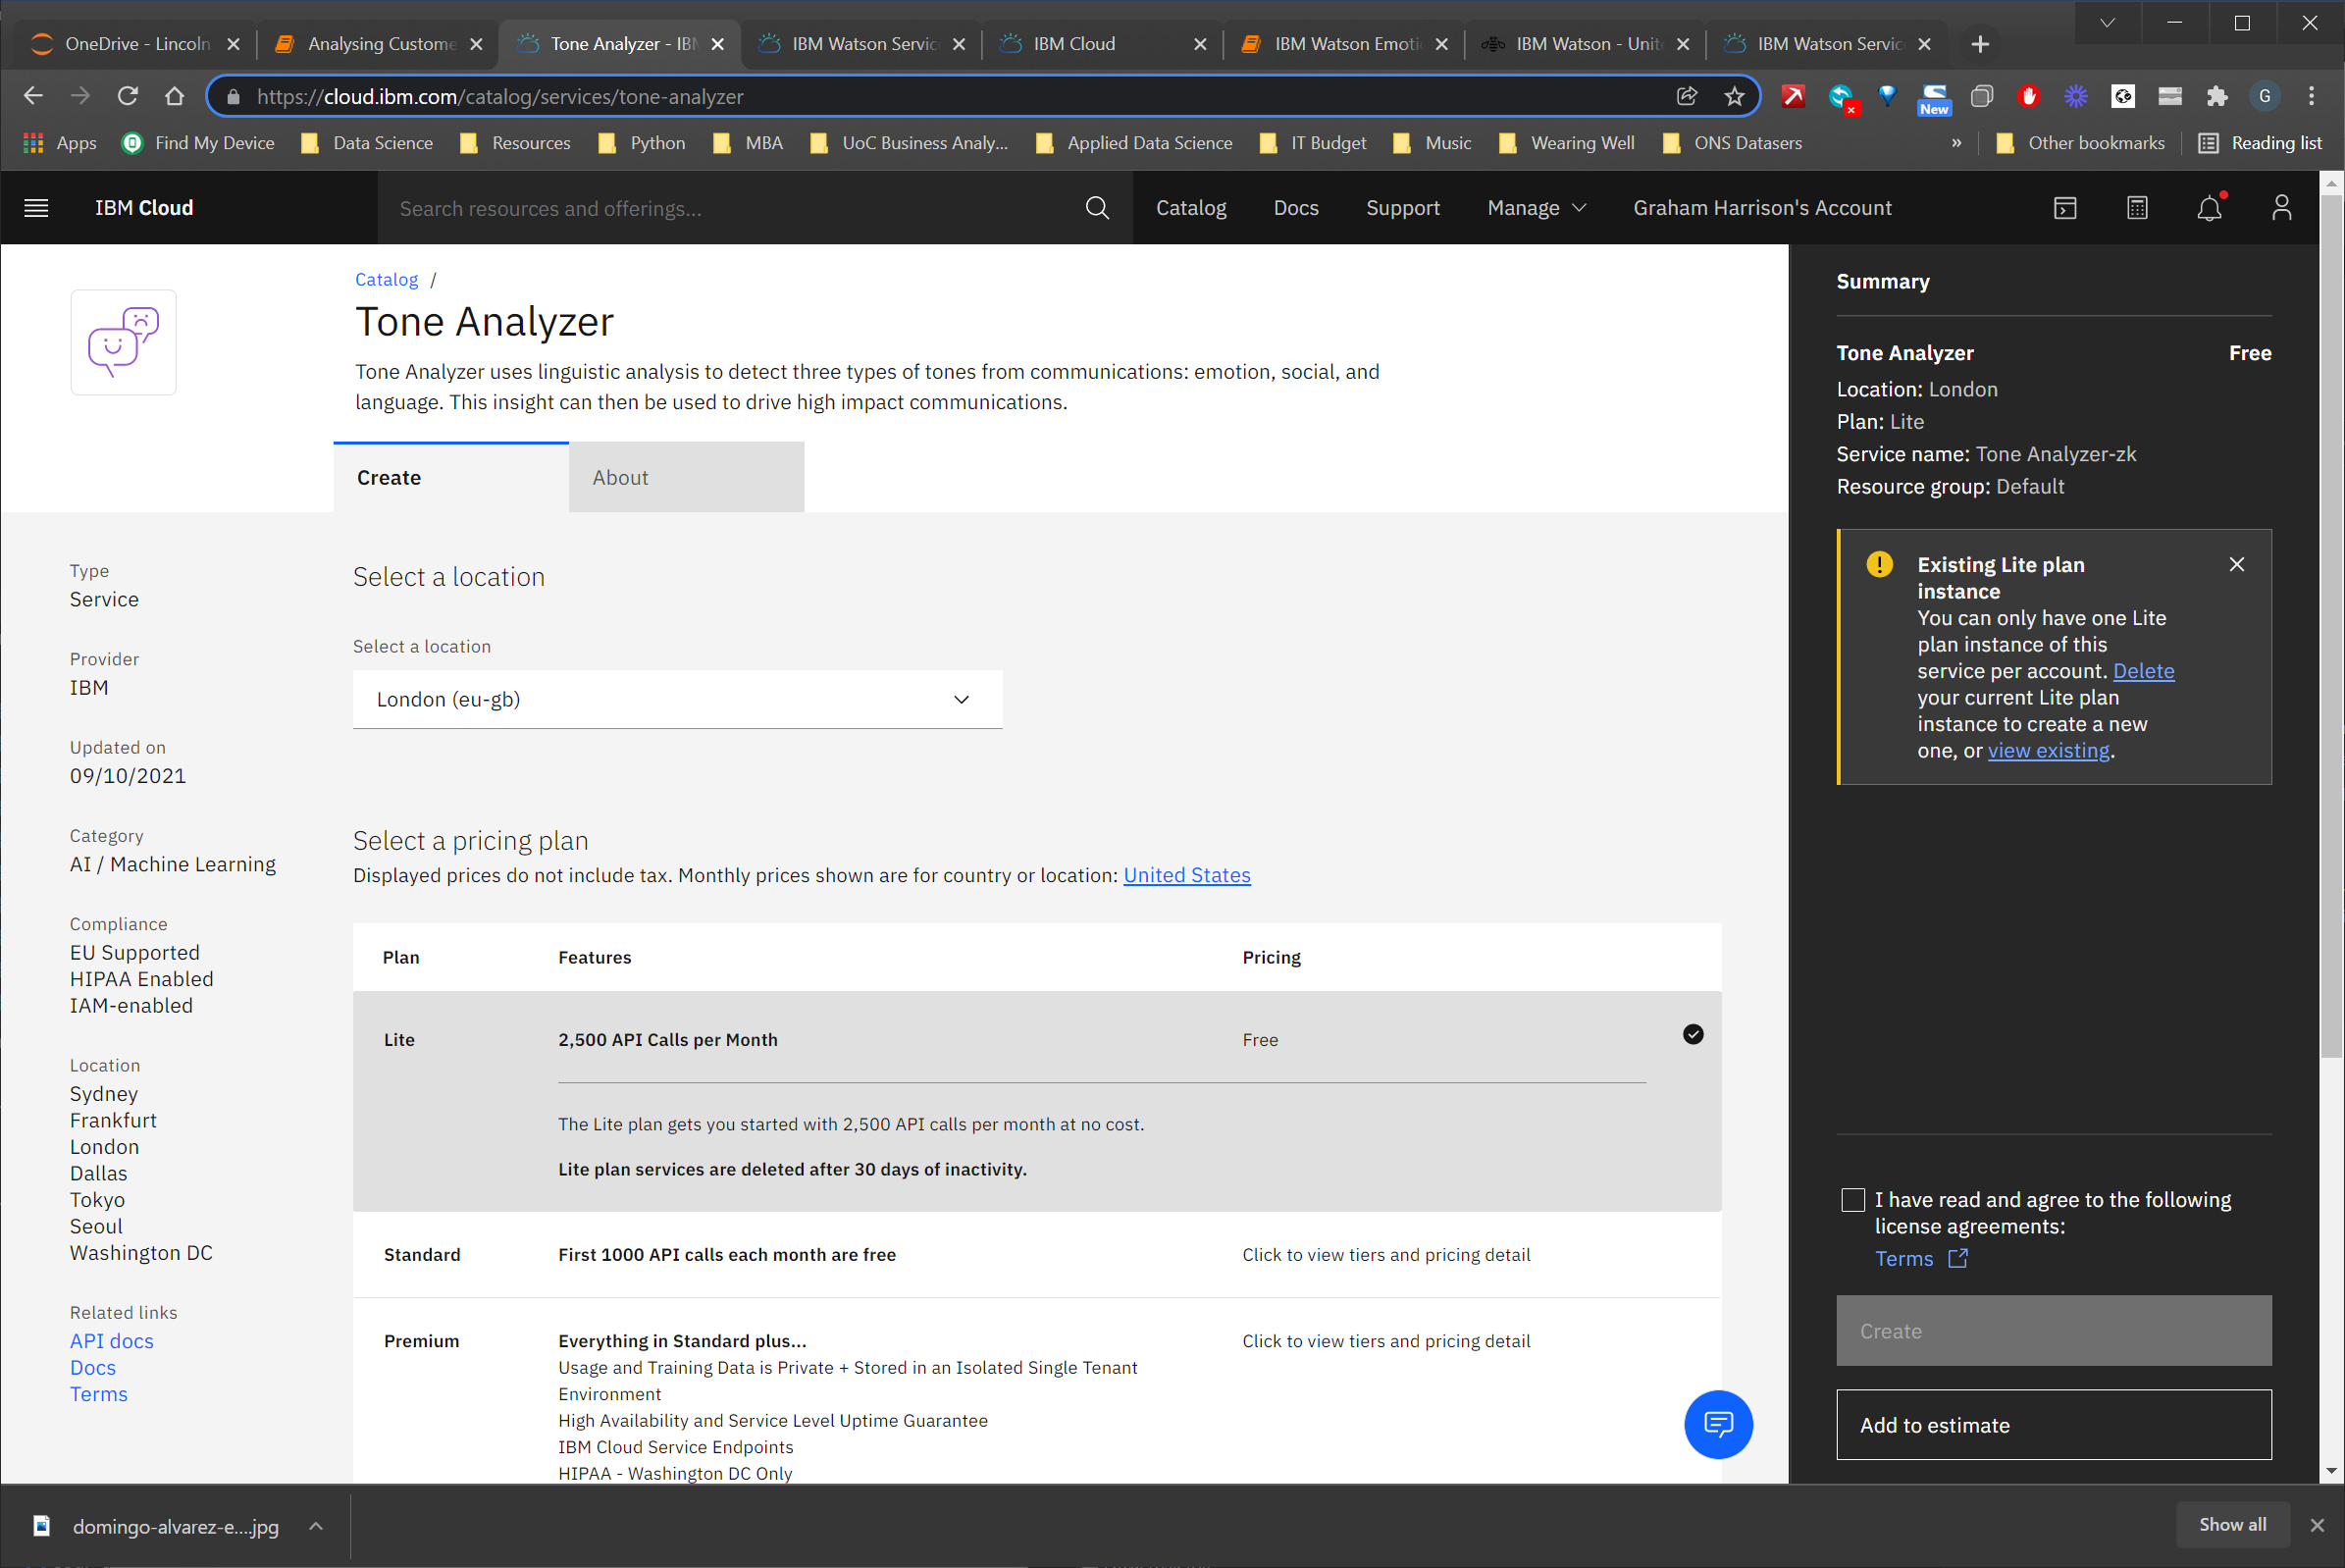
Image by Author

The "Lite" plan offers 2,500 API calls per month at no charge but you have to keep using it or it gets deleted which is no big deal except you will have to create a new API key if it has been removed. 

If you need more that 2,500 API calls per month you can move onto the standard plan which is \\$0.0088 per API call which equates to \\$88 (~£65) for 10,000 calls.

#### 3. Generating an API Key and URL
Once you have created a Lite plan you can navigate to it from this page by clicking the "View existing" link on the toolbar on the right hand side of the screen to go to the next step where you will create your API key ...

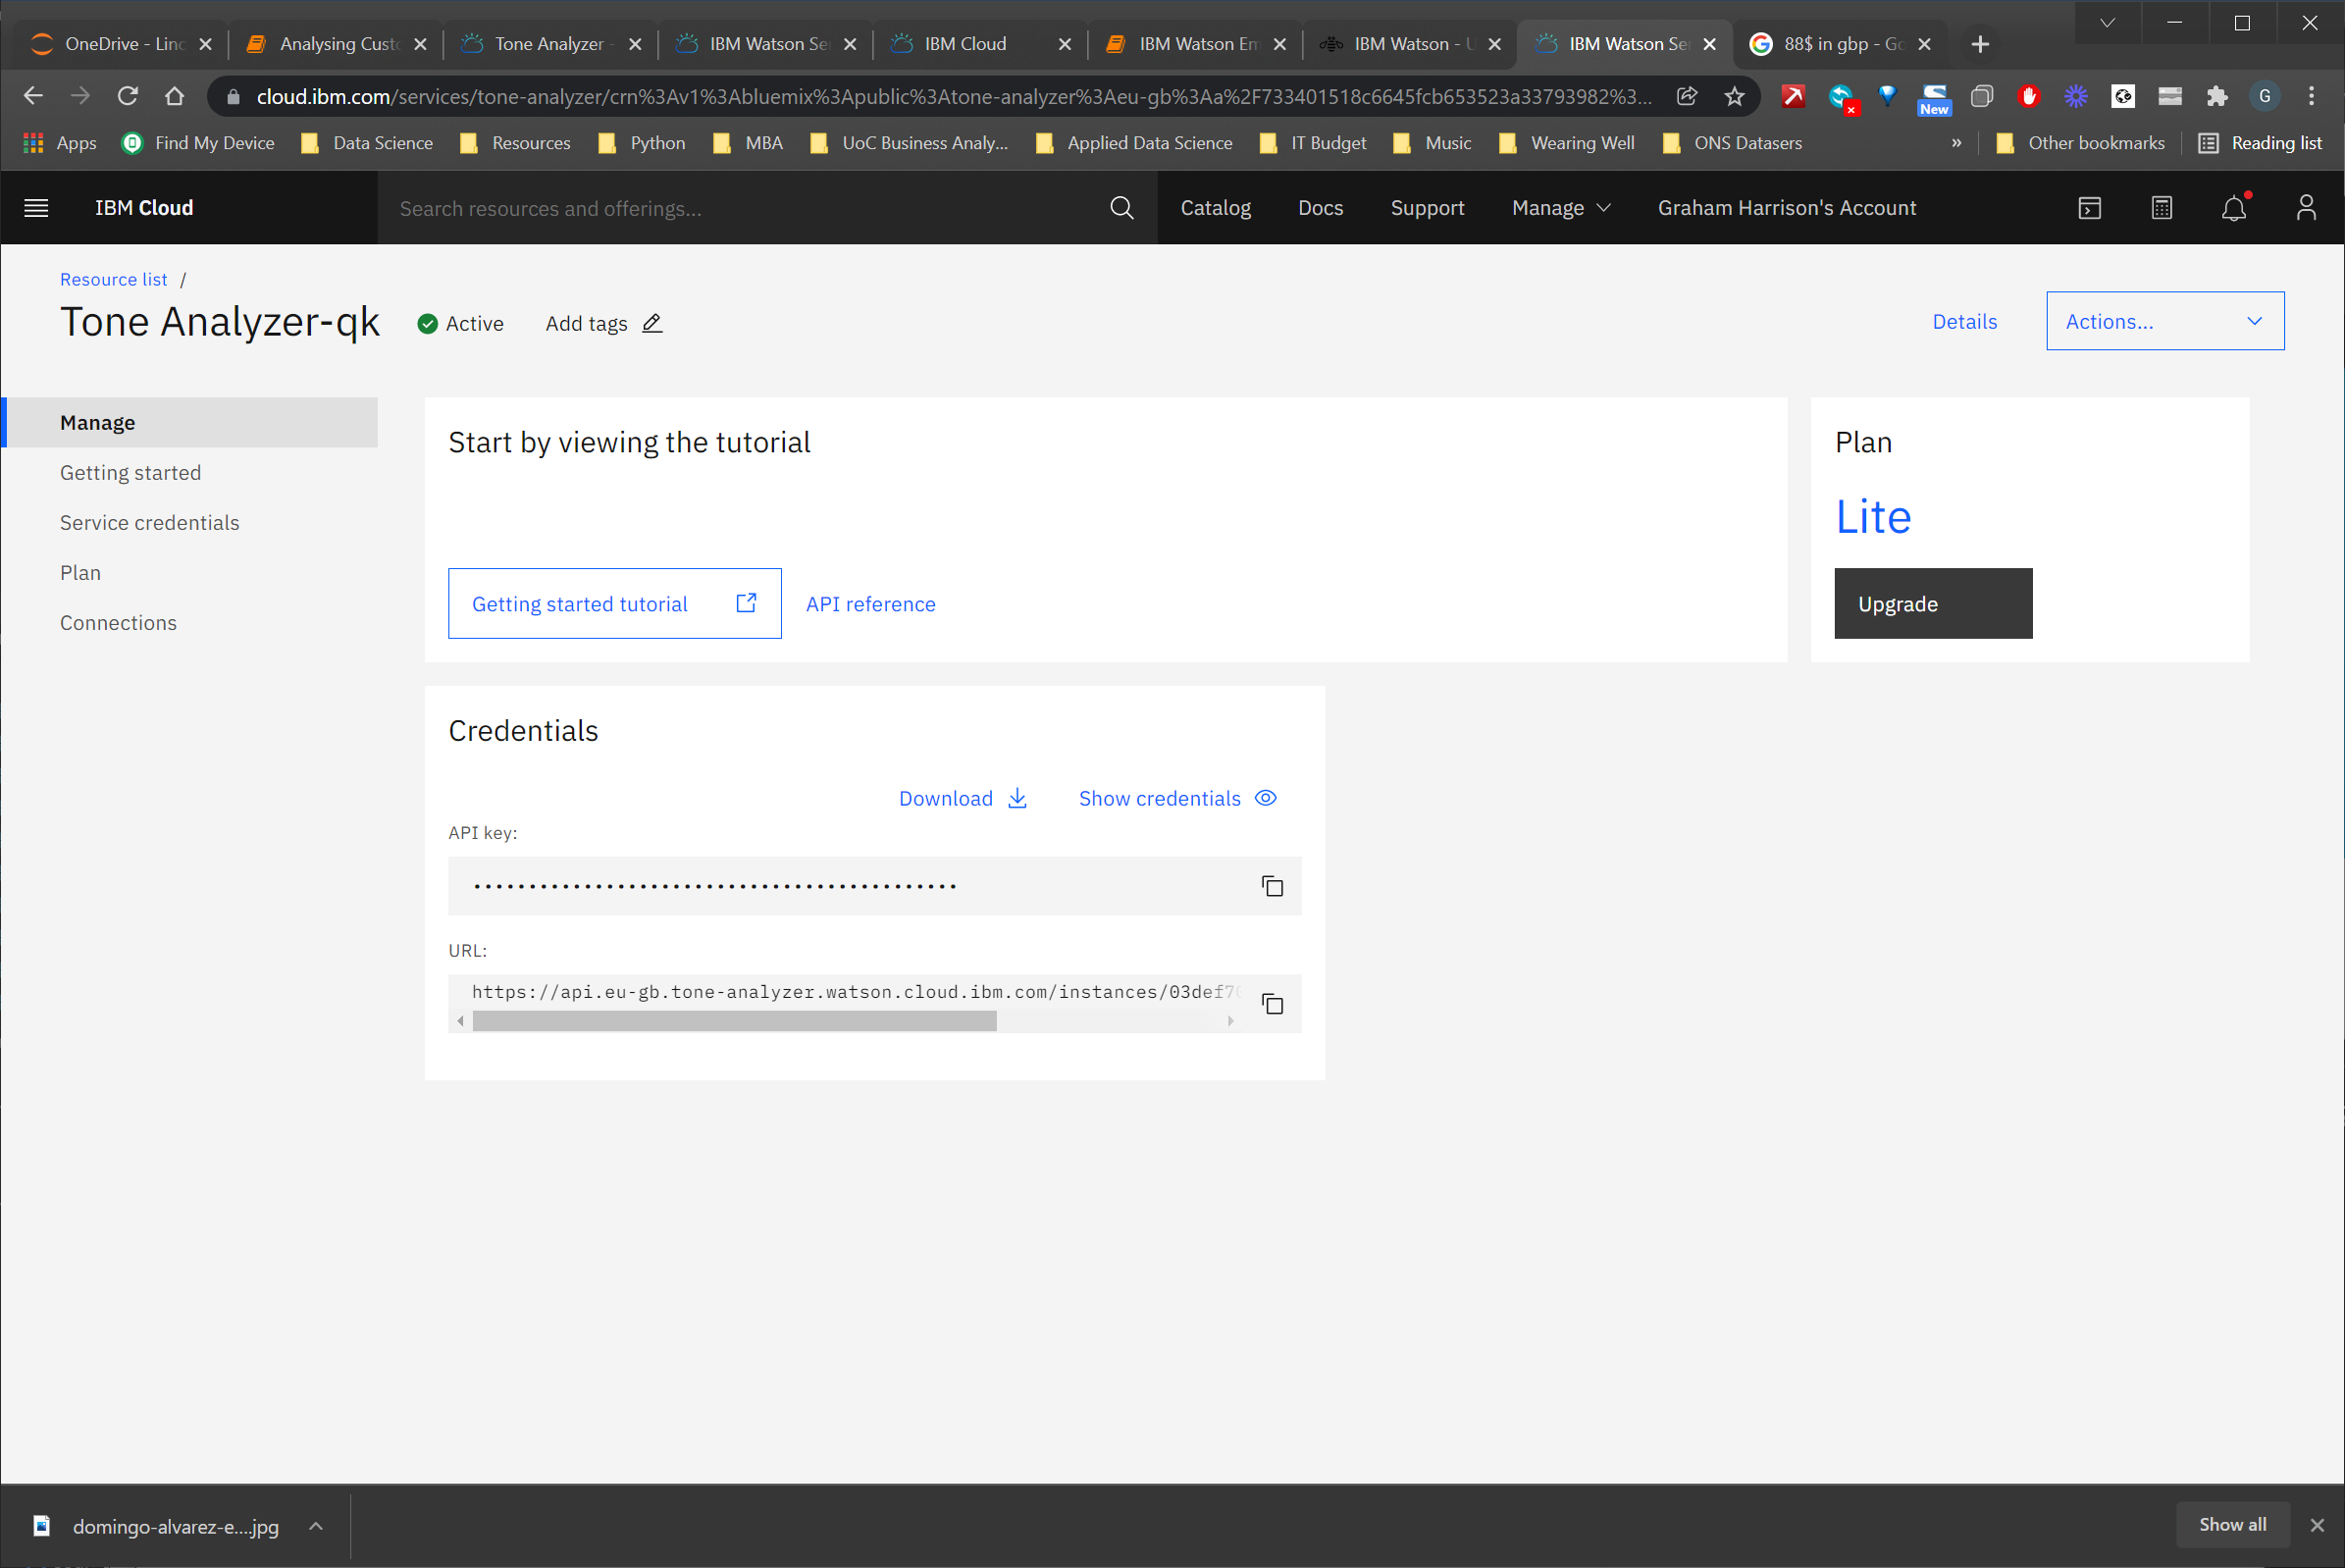
Image by Author

The screen-shot above shows an existing API key - you will need to copy both the key and the URL in order to start using the service. If you have not yet created a key there will be a button to create one on this page.

Take a careful note of your API key and URL and you are all set with an IBM Watson account, Tone Analyzer plan and API key and you can move onto the next stage where we will use the service to preform some emotional tone analysis ...

### Getting Some Data

#### 1. Choosing a Dataset
The next thing we need is some test data to test the IBM Watson Emotion Tone Analyser against and I have chosen a dataset of 23,000 women's e-commerce clothing reviews from Kaggle (https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews).

This dataset is excellent for developing and testing solutions around customer feedback and text analysis and it is licensed under the "CC0: Public Domain" license which means that "you can copy, modify, distribute and perform the work, even for commercial purposes, all without asking permission" (see https://creativecommons.org/publicdomain/zero/1.0/).

#### 2. Loading the Dataset
Let's start by reading in the data and by performing some limited data cleaning, feature engineering and sample selection -

In [1]:
import pandas as pd

df_reviews = pd.read_csv("data/in/Womens Clothing E-Commerce Reviews.csv")

df_reviews = df_reviews.iloc[:,1:] # Drop the first column which is an un-named internal index
df_reviews.drop_duplicates(inplace=True) # There are 21 duplicate rows in the data that will be dropped
df_reviews.dropna(inplace=True) # There are 3803 records remaining with nulls in the data; those rows will be removed
df_reviews = df_reviews.sample(n=500, random_state=42).reset_index(drop=True) # Finally sample 500 rows from the clean data and use a random_state for repeatability

df_reviews.head()

Clothing ID  Age  ... Department Name Class Name
0          850   64  ...            Tops    Blouses
1          829   30  ...            Tops    Blouses
2         1008   33  ...         Bottoms     Skirts
3          872   37  ...            Tops      Knits
4          862   59  ...            Tops      Knits

[5 rows x 10 columns]

Note that the Lite plan for IBM Watson is limited to 2,500 API calls per months, hence ``df_reviews.sample`` will limit the amount of times the API is called and keep within the plan.

### Configuring and Preparing the IBM Watson Tone Analyzer

#### 1. Installing the IBM Watson Libraries
You will need to install the libraries using pip or conda ...

```
pip install ibm-watson
```

I found that I had to manually select a version upgrade using the following command following the deprecation of some features that I had been using ...

```
pip install --upgrade "ibm-watson>=4.5.0"
```

#### 2. Initialising IBM Watson
The next thing we need to do is to authenticate using our API key and URL and to initiate the tone analyzer. We also need to be careful to keep the API key private and I find a good way to do this is to keep the URL and API key in a separate file called ``config.py`` and to exclude this file from github so no-one else can find the details. 

##### 2.1 Instruct GitHub to exclude the config file
Simply create a file called ``.gitignore`` in the root of your GitHub project using a text editor and on the first line enter ``config.py``. 

##### 2.2 Create a config.py file and add the constants
Replace the XXX's with your details
```
IBM_WATSON_URL = "https://api.eu-gb.tone-analyzer.watson.cloud.ibm.com/instances/XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
IBM_WATSON_API_KEY = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
```

##### 2.3 Authenticate and Connect

In [2]:
from ibm_watson import ToneAnalyzerV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

import config

ibm_watson_authenticator = IAMAuthenticator(config.IBM_WATSON_API_KEY)
ibm_watson_tone_analyzer = ToneAnalyzerV3(version='2017-09-21', authenticator=ibm_watson_authenticator)
ibm_watson_tone_analyzer.set_service_url(config.IBM_WATSON_URL)

### Using the IBM Watson Tone Analyzer to Predict and Visualise Emotions

The basic approach is to call the API once for every line of data using ``apply`` and a ``lambda`` function with the slight complication that we want to set the values in two columns in the ``DataFrame`` (``Main Emotion`` and ``Main Emotion Score``). 

The Python syntax for setting values in two columns is not immediately obvious and this thread on stackoverflow was invaluable in working out the solution - https://stackoverflow.com/questions/47983466/create-multiple-pandas-dataframe-columns-from-applying-a-function-with-multiple.

#### 1. Writing a Helper Function to Call the API for a Single Row

In [4]:
import json
import numpy as np

EMOTIONAL_TONES = ["Anger", "Disgust", "Fear", "Joy", "Sadness"]

def get_emotion(text : str) -> pd.Series:

    json_output = ibm_watson_tone_analyzer.tone({'text': text}, content_type='application/json').get_result() # Get json

    main_emotion = ""
    high_score = 0.0

    for tone in json_output["document_tone"]["tones"]: # iterate through the tones
        if tone["tone_name"] in EMOTIONAL_TONES and tone['score'] > high_score:
            main_emotion = tone['tone_name']
            high_score = tone["score"]

    return pd.Series((main_emotion, np.nan if main_emotion == "" else high_score))

Some points to note -

- The IBM Watson tone analyser can return different categories of tone but for the purposes of this analysis we are only interested in the emotions which are filtered using the values in the ``EMOTIONAL_TONES`` list.
- Each tone returned will have a name and a score, hence the code that stores the highest scoring emotional tone name and value.
- ``return pd.Series...`` is the required syntax for setting values in two columns using pandas ``apply`` and a ``lambda`` function.

To fully understand the code it is necessary to take a look at how the json output is structured for a single API call -

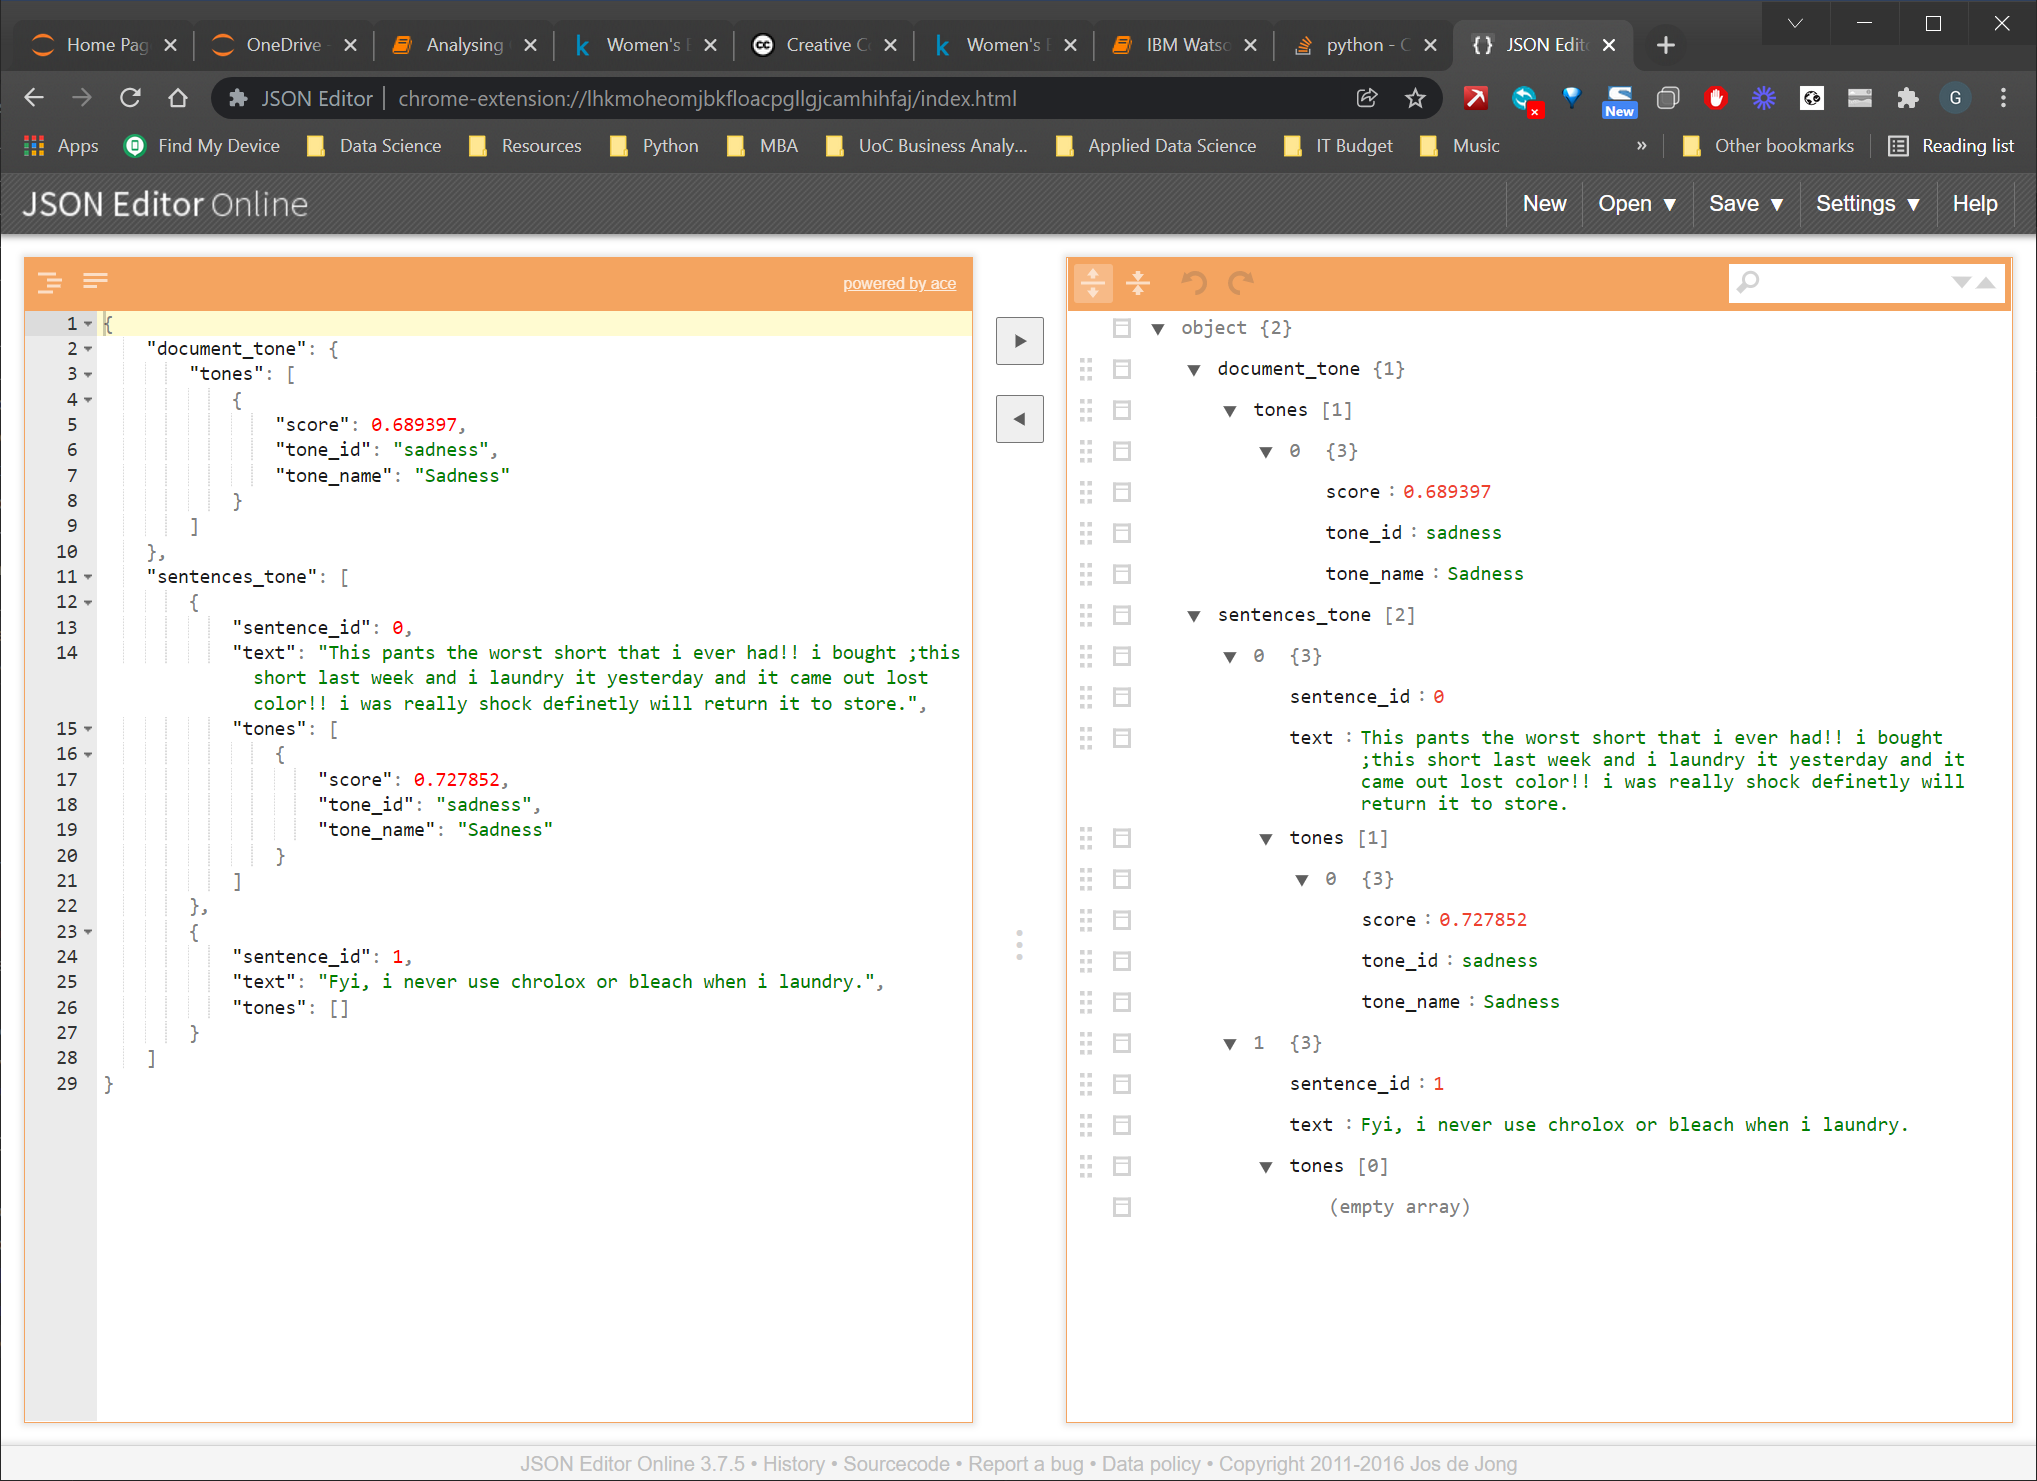

I have used the Google Chrome JSON Editor App to view the output (see https://chrome.google.com/webstore/detail/json-editor/lhkmoheomjbkfloacpgllgjcamhihfaj?hl=en) but there are other options available, for example the Visual Studio Code Json Editor extension.

You can see from the editor that each sentence has a tone and the overall text has a tone which is extracted by the code. There is only a single tone shown here but more complex text will result in multiple tones being returned with a mixture of emotions and non-emotions. The code provided deals with all combinations of data returned by the API.

#### 2. Calling the Helper Function

Now all that remains is to invoke the helpder function for each row in the dataset and to set the values of two features simultaneously based on the values returned by the ``get_emotion`` function for each row ...

In [5]:
df_reviews[['Main Emotion', 'Main Emotion Score']] = df_reviews['Review Text'].apply(lambda text: get_emotion(text))

In [6]:
df_reviews.head()

Clothing ID  Age  ... Main Emotion Main Emotion Score
0          850   64  ...          Joy           0.588694
1          829   30  ...          Joy           0.806345
2         1008   33  ...          Joy           0.626453
3          872   37  ...          Joy           0.693493
4          862   59  ...                             NaN

[5 rows x 12 columns]

#### 3. Saving the Results
To avoid having to call the API multiple times which would use up the Lite plan monthly limit we will save the results into an Excel spreadsheet ...

In [8]:
df_reviews.to_excel("data/out/Womens Clothing E-Commerce Reviews with Emotions.xlsx", index=False, sheet_name="reviews")

#### 4. Visualising the Results
Finally here is a visualisation of the the prevailing customer emotions using a pie-chart ...

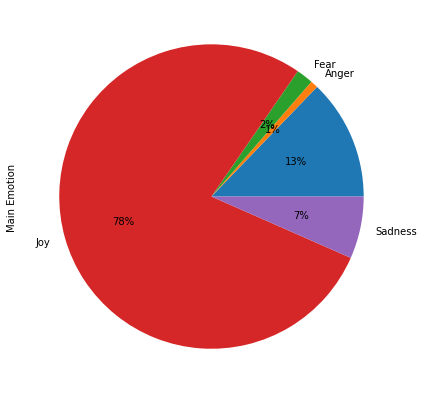

In [27]:
import matplotlib.pyplot as plt
ax = df_reviews.groupby('Main Emotion').size().plot(kind='pie', autopct = lambda p:f'{p:.0f}%', figsize=(7,7))
ax.set_ylabel("Main Emotion")
plt.show()

### Conclusion

We have seen how to register for an account with IBM Watson and the create a free plan for 2,500 API calls per month into the Tone (emotion) Analyzer.

We have also developed code in Python to apply the emotion predictions to a public license dataset and then stored and visualised the results.

If we had applied this approach to all 23,000 data points in the women's e-commerce clothing reviews dataset the cost would have been \\$202 (~£149) and it would have taken about 4 hours for the code to run.

In conclusion the IBM Watson Tone Analyzer is an effective and economic way to make predictions of customer emotions for small-medium datasets but processing time and cost may preclude it for use on big data.

However the IBM Watson engine has been trained using 100's of 1000's of data points and hence it is an effective predictor so potentially this approach could be used on a sample of data in a larger dataset as has been done in this example to make predictions about the patterns in the population data.

### Thank you for reading!

If you enjoyed reading this article, why not check out my other articles at https://grahamharrison-86487.medium.com/?
Also, I would love to hear from you to get your thoughts on this piece, any of my other articles or anything else related to data science and data analytics.

If you would like to get in touch to discuss any of these topics please look me up on LinkedIn — https://www.linkedin.com/in/grahamharrison1 or feel free to e-mail me at GHarrison@lincolncollege.ac.uk.

If you would like to support the author and 1000’s of others who contribute to article writing world-wide by subscribing, please use this link — https://grahamharrison-86487.medium.com/membership (note: the author will receive a proportion of the fees if you sign up using this link).